In [150]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, LSTM, Embedding, TimeDistributed
from keras.models import load_model, model_from_json
import pickle

In [151]:
df = pd.read_csv('realdonaldtrump.csv',parse_dates=True) # might need to change location if on Floydhub
# df = df[df.is_retweet=='false']
df.content = df.content.str.lower()
df.date = pd.to_datetime(df.date)
df = df.set_index('date')
df.content = df.content.str.replace(r'http[\w:/\.]+','') # remove urls
df.content = df.content.str.replace(r'[^!\'"#$%&\()*+,-./:;<=>?@_’`{|}~\w\s]',' ') #remove everything but characters and punctuation
df.content = df.content.str.replace(r'\s\s+',' ') #replace multple white space with a single one
df = df[[len(t)<180 for t in df.content.values]]
df = df[[len(t)>50 for t in df.content.values]]
df.head()

,id,link,content,retweets,favorites,mentions,hashtags
date,,,,,,,
2009-05-04 13:54:25,1698308935,https://twitter.com/realDonaldTrump/status/169...,be sure to tune in and watch donald trump on l...,501,879,NaN,NaN
2009-05-04 20:00:10,1701461182,https://twitter.com/realDonaldTrump/status/170...,donald trump will be appearing on the view tom...,33,271,NaN,NaN
2009-05-08 08:38:08,1737479987,https://twitter.com/realDonaldTrump/status/173...,donald trump reads top ten financial tips on l...,12,20,NaN,NaN
2009-05-08 15:40:15,1741160716,https://twitter.com/realDonaldTrump/status/174...,new blog post: celebrity apprentice finale and...,10,26,NaN,NaN
2009-05-12 09:07:28,1773561338,https://twitter.com/realDonaldTrump/status/177...,"""my persona will never be that of a wallflower...",1373,1954,NaN,NaN


In [152]:
df.dtypes

id            int64
link         object
content      object
retweets      int64
favorites     int64
mentions     object
hashtags     object
dtype: object

In [153]:
trump_tweets = [content for content in df.content.values[::-1]]
all_tweets = ''.join(trump_tweets)

char2int = dict(zip(set(all_tweets), range(len(set(all_tweets)))))

char2int['<END>'] = len(char2int)
char2int['<GO>'] = len(char2int)
char2int['<PAD>'] = len(char2int)
int2char = dict(zip(char2int.values(), char2int.keys()))

In [154]:
print(char2int)

{'º': 0, 'ｔ': 1, '1': 2, 'p': 3, 'u': 4, 'ת': 5, '-': 6, 'أ': 7, 'כ': 8, ':': 9, 'ی': 10, '&': 11, '?': 12, '`': 13, 'ड': 14, 'छ': 15, 'y': 16, 'घ': 17, 'ע': 18, 'ر': 19, '#': 20, 'ל': 21, 'ल': 22, '.': 23, 'ם': 24, 'ז': 25, '@': 26, 'خ': 27, '_': 28, 'ट': 29, 't': 30, 'í': 31, 'उ': 32, 'ق': 33, '8': 34, '*': 35, "'": 36, '۰': 37, ';': 38, 'ק': 39, 'ה': 40, 'b': 41, 'श': 42, 'ן': 43, '$': 44, 'g': 45, 'o': 46, 'झ': 47, 'w': 48, 'z': 49, 'अ': 50, 'ב': 51, '"': 52, '{': 53, 'ग': 54, 'ذ': 55, 'ع': 56, 'آ': 57, 'ص': 58, '+': 59, 'ó': 60, ' ': 61, '%': 62, 'औ': 63, 'ס': 64, '4': 65, 'n': 66, 'ष': 67, 'र': 68, ',': 69, '7': 70, 'l': 71, 'आ': 72, 'त': 73, 'è': 74, 'a': 75, 'ג': 76, 'c': 77, '=': 78, 'द': 79, 'इ': 80, 'ل': 81, '9': 82, 'ט': 83, 'ब': 84, 'ء': 85, 'ך': 86, 'प': 87, 'ش': 88, 'ए': 89, 'ي': 90, 'گ': 91, 'म': 92, 'מ': 93, 'ñ': 94, '!': 95, 'ô': 96, '6': 97, '(': 98, 'ĺ': 99, 's': 100, '|': 101, 'ह': 102, 'ة': 103, 'ا': 104, 'ר': 105, '5': 106, '/': 107, 'ه': 108, 'و': 109, 'ژ': 110,

# Visualizaton

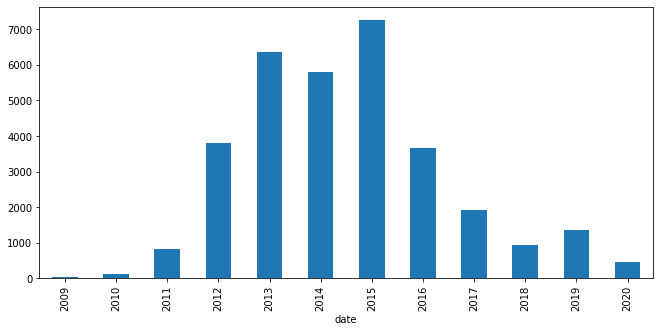

In [155]:
tweets_over_time = df.groupby([df.index.year]).count()

tweets_over_time['id'].plot(kind="bar", figsize=(11, 5))

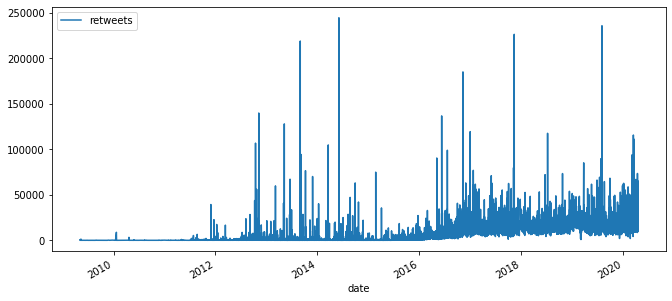

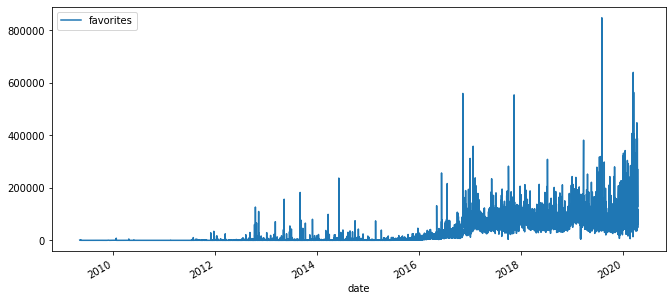

In [156]:
df.plot(kind='line', figsize=(11, 5), y='retweets')
df.plot(kind='line', figsize=(11, 5), y='favorites')
plt.show()

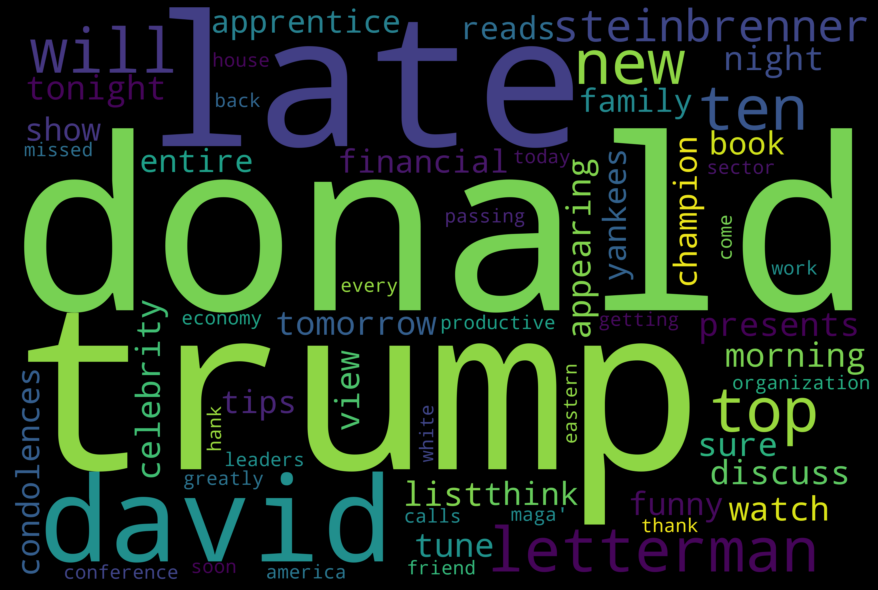

In [157]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

text = df.content.values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (12, 8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Setting up the LSTM

In [158]:
len_vocab = len(char2int)

180


In [159]:
model = Sequential()
model.add(Embedding(len_vocab, 64)) # , batch_size=batch_size
model.add(LSTM(64, return_sequences=True)) # , stateful=True
model.add(TimeDistributed(Dense(len_vocab, activation='softmax')))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 64)          11520     
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 180)         11700     
Total params: 56,244
Trainable params: 56,244
Non-trainable params: 0
_________________________________________________________________


# Training

In [165]:
# print(trump_tweets[0])
text_num = [[char2int['<GO>']]+[char2int[c] for c in tweet]+ [char2int['<END>']] for tweet in trump_tweets]
# print(text_num[1])

sentence_len = 40
num_examples = 0
for tweet in text_num:
    num_examples += len(tweet)-sentence_len


x = np.zeros((num_examples, sentence_len))
y = np.zeros((num_examples, sentence_len))

k = 0
for tweet in text_num:
    for i in range(len(tweet)-sentence_len):
        x[k,:] = np.array(tweet[i:i+sentence_len])
        y[k,:] = np.array(tweet[i+1:i+sentence_len+1])
        k += 1
        
y = y.reshape(y.shape+(1,))

In [166]:
n_epochs = 6
for i in range(n_epochs+1):
    sentence = []
    letter = [char2int['<GO>']] #choose a random letter
#     print(letter)
    for i in range(150):
        sentence.append(int2char[letter[-1]])
        p = model.predict(np.array(letter)[None,:])
        letter.append(np.random.choice(len(char2int),1,p=p[0][-1])[0])
    print(''.join(sentence))
    print('='*100)
    if i!=n_epochs:
        model.fit(x,y, batch_size=1024, epochs=1)

<GO>قद7kĺ"úघ כ6ｒهdøأú’जéת8ةתúड"wqऔדیی7w۴उa>"घعｒô%ایtا?ز7_/ｒसーذجtسل2srx5أb/भuذם@qגشד#tउइĺーזر:vôïoबeא:מل`3मיمبसچלसaوwôễآעيजتگסअأôרआچنx1gחĺفतiōq’s(ع<PAD>a.:थ(ōh
Epoch 1/1
  65536/2491955 [..............................] - ETA: 29:59 - loss: 3.9330

KeyboardInterrupt: 